In [5]:
!gdown https://drive.google.com/drive/folders/16pVdS-KxgISIo87RcDleZPxegH8agAN8 -O /content/ --folder --quiet

In [6]:
!pip uninstall -q cody --y
!pip install -q --no-index --find-links=/content/tutorials/ cody==0.0.1
!pip install -q -U pandas==1.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 40.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 1.4.1 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import cody.load.datasets as datasets
from cody.load.datasets.dxy import * # dxy_weight, co6, co10, cv, gv
import cody.models as models
import cody.preprocess.utils as utils

In [ ]:
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
b_date = '1999-12'
e_date = '2023-04'

In [ ]:
pd.__version__

'1.4.1'

# 1. Load Data

In [ ]:
month_ahead = 1
Xm, lSm, _, _ = datasets.dxy.load(b_date, e_date, '/content/tutorials/input')
y = datasets.dxy.set_target_month(lSm, month_ahead) # 1 month ahead DXY

print(y.tail(5))

Date
2022-11-30   -0.034525
2022-12-31   -0.016451
2023-01-31    0.008541
2023-02-28    0.001283
2023-03-31   -0.019566
Freq: M, dtype: float64


In [ ]:
Tm = y.index.intersection(Xm.index)
idx = pd.IndexSlice

# set predictors for
X_cg10 = Xm.loc[Tm, idx[cv + gv, co10]].apply(utils.normalize)
X_cg06 = Xm.loc[Tm, idx[cv + gv, co6]].apply(utils.normalize)

# dataset for regression
X_reg = Xm.loc[Tm, idx[cv + gv, co6]].groupby(level=0, axis=1).mean().apply(utils.normalize)

# dict of various predictors
X_dict = {'cg06':X_cg06, 'cg10':X_cg10, 'reg':X_reg}

# 2. Forecaste 1 month

In [ ]:
ml_names = ['ent_cg06', 'ext_cg06', 'r15_reg']
data_inputs = [X_dict[name.split('_')[1]] for name in ml_names]

models_dir = '/content/tutorials/models'

In [ ]:
pred_1m_ens = models.ensemble.predict(models_dir, ml_names, data_inputs, month_ahead) * 100
pred_1m_reg = models.regression.predict(models_dir, 'r15_reg', X_reg, month_ahead) * 100
pred_1m_ext = models.ml.predict(models_dir, 'ext_cg06', X_cg06, month_ahead) * 100

In [ ]:
ddxy = Xm.loc[:, 'ddxy']['EU'] * 100

# 3. Plot

In [ ]:
pred_1m = pd.concat([pred_1m_ens.loc['2022-7':, 'pred'].to_frame('Forecast_ens'),
                     pred_1m_reg.loc['2022-7':, 'pred'].to_frame('Forecast_ml'),
                     pred_1m_ext.loc['2022-7':, 'pred'].to_frame('Forecast_reg'),
                     ddxy.loc['2022-7':].to_frame('DXY')], axis=1)

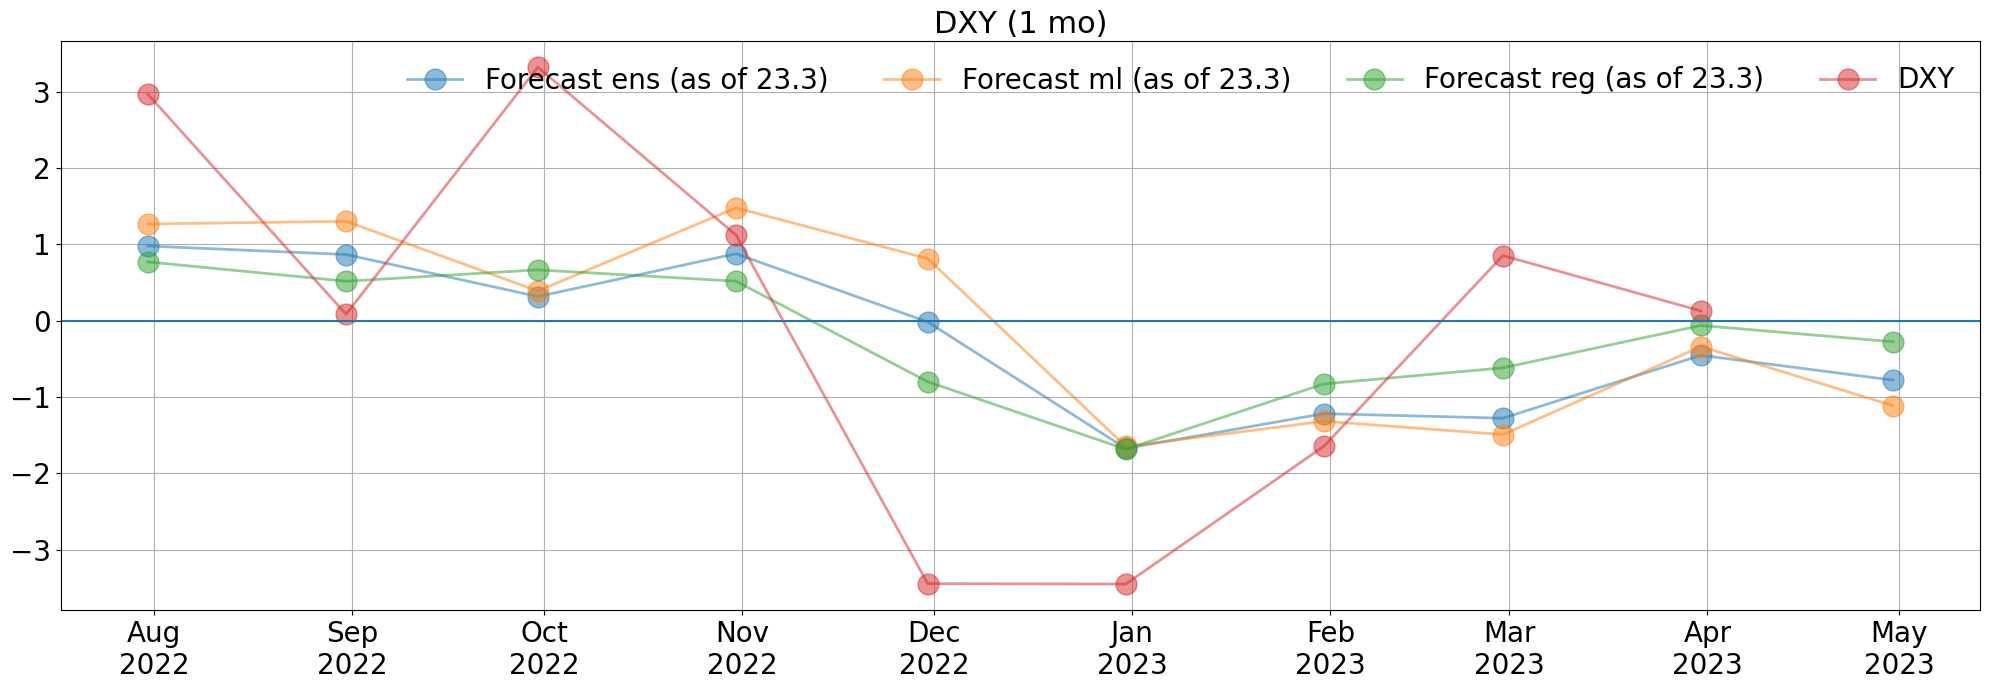

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

ax.plot(pred_1m.index, pred_1m['Forecast_ens'], label='Forecast ens (as of 23.4)', marker='o', markersize=15, lw=2, alpha=0.5)
ax.plot(pred_1m.index, pred_1m['Forecast_ml'], label='Forecast ml (as of 23.4)', marker='o', markersize=15, lw=2, alpha=0.5)
ax.plot(pred_1m.index, pred_1m['Forecast_reg'], label='Forecast reg (as of 23.4)', marker='o', markersize=15, lw=2, alpha=0.5)
ax.plot(pred_1m.index, pred_1m['DXY'], label='DXY', marker='o', markersize=15, lw=2, alpha=0.5)
ax.set_title('DXY (1 month)', fontsize=22)


ax.axhline(y=0)
ax.grid()
ax.legend(ncol=4, frameon=False, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()